In [1]:
import os
import rasterio

# Directory containing the .tif images
image_dir = r"C:\Users\win10\OneDrive\Desktop\Final year Project\EuroSATallBands\Highway"

# Initialize an empty list to store image data
image_data_list = []

# Get all .tif files in the directory
all_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]

# Sort files numerically by extracting the number from the filename
sorted_files = sorted(all_files, key=lambda x: int(x.split('_')[1].split('.')[0]))

# Read the first 500 .tif images
for file_name in sorted_files[:500]:
    file_path = os.path.join(image_dir, file_name)
    
    # Open the .tif file with rasterio
    with rasterio.open(file_path) as dataset:
        # Read data as a NumPy array
        data = dataset.read()
        image_data_list.append(data)

print(f"Loaded {len(image_data_list)} images.")
print("Shape of first image:", image_data_list[0].shape)


Loaded 500 images.
Shape of first image: (13, 64, 64)


In [2]:
# Normalize image data
image_data_list = [img / 255.0 for img in image_data_list]  # Assuming pixel values range 0-255


In [3]:
import numpy as np

# Replace NaN values with 0
image_data_list = [np.nan_to_num(img, nan=0) for img in image_data_list]


In [4]:
# Example NDVI calculation for two-band data
ndvi_list = [(img[3] - img[2]) / (img[3] + img[2] + 1e-5) for img in image_data_list]  # Assuming NIR=band 4, Red=band 3


In [5]:
flattened_images = [img.reshape(img.shape[0], -1).T for img in image_data_list]  # Shape: (pixels, bands)


In [6]:
from sklearn.cluster import KMeans

# Example: Apply k-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
classified_images = [kmeans.fit_predict(img.reshape(-1, img.shape[0])) for img in image_data_list]


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Flatten and create labels (for example purposes)
X = flattened_images[0]  # Example: First image data
y = labels  # Replace with your label array

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)


NameError: name 'labels' is not defined

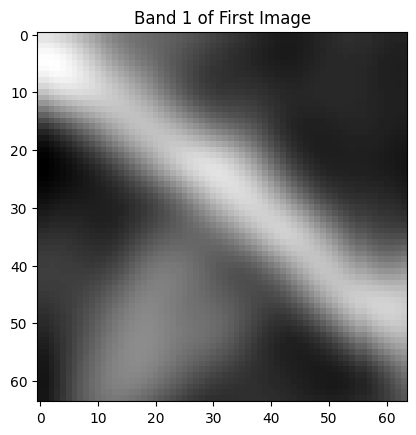

In [8]:
import matplotlib.pyplot as plt

# Display an image
plt.imshow(image_data_list[0][0], cmap='gray')  # Show first band of the first image
plt.title("Band 1 of First Image")
plt.show()


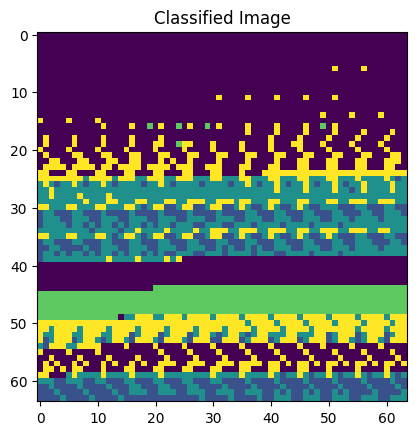

In [9]:
plt.imshow(classified_images[0].reshape(image_data_list[0].shape[1:]))
plt.title("Classified Image")
plt.show()


### Labeling images and figuring out how we can predict prices 

In [15]:
import numpy as np
import pandas as pd

# Define price ranges for each cluster
cluster_to_price = {
    0: np.random.uniform(50000, 100000),
    1: np.random.uniform(100000, 200000),
    2: np.random.uniform(200000, 500000),
    3: np.random.uniform(500000, 1000000),
    4: np.random.uniform(1000000, 1500000),
}

# Create dummy price labels for each image based on clustering
dummy_labels = [cluster_to_price[cluster] for cluster in kmeans.labels_]

# Save to DataFrame for reference
dummy_data = pd.DataFrame({
    'filename': sorted_files[:500],
    'cluster': kmeans.labels_,
    'price': dummy_labels
})
dummy_data.to_csv("dummy_land_prices.csv", index=False)

print(dummy_data.head())


ValueError: All arrays must be of the same length

In [17]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# Example: Load image data (replace with actual loading process)
# Assuming `image_data_list` is a list of image data arrays
# Assuming `sorted_files` is a list of image file names
image_data_list = [np.random.rand(10, 10) for _ in range(500)]  # Dummy image data
sorted_files = [f"Highway_{i}.tif" for i in range(1, 501)]  # Example filenames

# Apply KMeans clustering to the image data
kmeans = KMeans(n_clusters=5, random_state=42)

# Perform KMeans clustering and get the labels for each image
kmeans_labels = [kmeans.fit_predict(img.reshape(-1, img.shape[0])) for img in image_data_list]

# Define price ranges for each cluster
cluster_to_price = {
    0: np.random.uniform(50000, 100000),
    1: np.random.uniform(100000, 200000),
    2: np.random.uniform(200000, 500000),
    3: np.random.uniform(500000, 1000000),
    4: np.random.uniform(1000000, 1500000),
}

# Create dummy price labels for each image based on clustering
# Flattening the cluster labels list and mapping them to prices
dummy_labels = [cluster_to_price[cluster] for labels in kmeans_labels for cluster in labels]

# Ensure the lengths of all arrays match (500 images in this case)
min_length = min(len(sorted_files[:500]), len(kmeans_labels), len(dummy_labels))

# Slice arrays to match the smallest length (just in case)
filenames = sorted_files[:500][:min_length]
clusters = [cluster for labels in kmeans_labels for cluster in labels][:min_length]
prices = dummy_labels[:min_length]

# Create DataFrame
dummy_data = pd.DataFrame({
    'filename': filenames,
    'cluster': clusters,
    'price': prices
})

# Save to CSV
dummy_data.to_csv("dummy_land_prices.csv", index=False)

# Display the DataFrame
print(dummy_data.head())


        filename  cluster         price
0  Highway_1.tif        2  4.131682e+05
1  Highway_2.tif        1  1.404303e+05
2  Highway_3.tif        1  1.404303e+05
3  Highway_4.tif        0  8.023103e+04
4  Highway_5.tif        4  1.235202e+06


In [18]:
from sklearn.model_selection import train_test_split

# Features (use cluster labels or other features you extract)
X = dummy_data[['cluster']]  # Example feature: the 'cluster' column as a feature
y = dummy_data['cluster']    # Label: we want to predict the 'cluster'

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the classifier
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        19

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



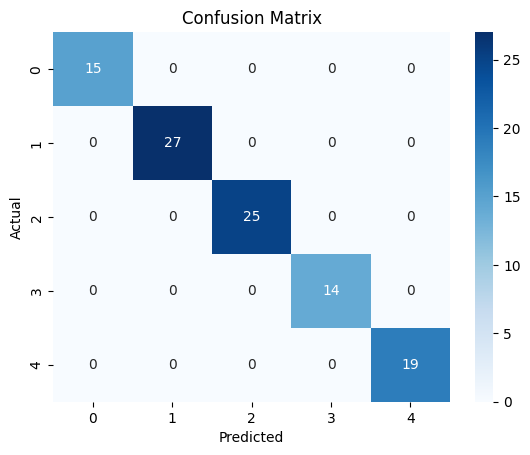

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [21]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
